In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
from tqdm import tqdm

import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [2]:
"""
Loading and preprocessing datasets from tensorflow-datasets
"""

train_data , info = tfds.load("fashion_mnist", split="train", with_info=True)
test_data = tfds.load("fashion_mnist", split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMOTRR5/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMOTRR5/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
"""
Checking dimensions of loaded tensorflow datasets
"""

Num_of_training_data = tf.data.experimental.cardinality(train_data).numpy()

print(Num_of_training_data)

print(train_data)

60000
<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [4]:
classes_name = [ "T-shirt/top","Trouser/pants", "Pullover shirt","Dress","Coat","Sandal", "Shirt", "Sneaker","Bag","Ankle boot" ]

In [5]:
"""
Normalizing the datasets 
"""

def Normalize_datasets(data):
  image = data["image"]
  # Rescaling image into a vector
  image = tf.reshape(image, [-1,])
  image = tf.cast(image,'float32')
  image = image/255.0
  return image , data["label"]

In [6]:
train_data = train_data.map(Normalize_datasets)
test_data = test_data.map(Normalize_datasets)

In [7]:
batch_size = 64

train = train_data.shuffle(buffer_size=1024).batch(batch_size)

dev = test_data.batch(batch_size)

In [8]:
"""
Defining deep neural network model using keras layers
"""

def base_model():

  inputs = tf.keras.Input(shape = (784,), name="clothing")
  x = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
  x = tf.keras.layers.Dense(64, activation="relu", name="dense_2")(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax" , name="predictions")(x)

  model = tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [9]:
"""
Defining optimizer and lossfunction
"""
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [10]:
"""
Defining mertics to keep a track-record of our model accuracy during training processs
"""

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [11]:
"""
Defining training loop with tensorflow gradient tape
"""

def apply_gradient(optimizer,model,x,y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true = y, y_pred = logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))  

  return logits,loss_value

In [12]:
"""
Defining train method for one epoch
"""

def train_data_for_one_epoch():
  losses = []
  pbar= tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}|{n_fmt}/{total_fmt}')

  for step, (x_batch_train, y_batch_train) in enumerate(train):
    logits,loss_value = apply_gradient(optimizer,model,x_batch_train,y_batch_train)

    losses.append(loss_value)

    train_acc_metric(y_batch_train,logits)
    pbar.set_description("Training loss for step %s: %.4f" % ( int(step), float(loss_value)))
    pbar.update()
  return losses


In [13]:
"""
Performing corss validation on development set after each epoch 
and calculating cross-accuracy
"""

def perform_validation():
  losses = []
  for x_val,y_val in dev:
    val_logits = model(x_val)
    val_loss = loss_object(y_true = y_val, y_pred = val_logits)
    losses.append(val_loss)

    val_acc_metric(y_val,val_logits)
  return losses 


In [19]:
"""
Training loop initialization
"""

def initialize_training():
  # Instance of main tensorflow model
  model = base_model()

  epochs = 10
  epoch_val_losses, epoch_train_losses = [],[]

  for epoch in range(epochs):

    print('Start of epoch %d'% (epoch,)) 

    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()

    losses_val = perform_validation()
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_dev_mean = np.mean(losses_val)

    epoch_val_losses.append(losses_train_mean)
    epoch_train_losses.append(losses_dev_mean)

    print("For epoch"+str(epoch)+", Train loss is = "+str(losses_train_mean)+", Dev loss is ="+str(losses_dev_mean)+" Train accuracy is ="+str(train_acc.numpy())+", Dev accuracy is "+str(val_acc.numpy()))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

initialize_training()



Start of epoch 0


Training loss for step 937: 0.2586: 100%|██████████|938/938


For epoch0, Train loss is = 0.24968503, Dev loss is =0.3680063 Train accuracy is =0.90718335, Dev accuracy is 0.8757
Start of epoch 1


Training loss for step 937: 0.2267: 100%|██████████|938/938


For epoch1, Train loss is = 0.24167061, Dev loss is =0.3427379 Train accuracy is =0.91006666, Dev accuracy is 0.8823
Start of epoch 2


Training loss for step 937: 0.2694: 100%|██████████|938/938


For epoch2, Train loss is = 0.23418896, Dev loss is =0.35741794 Train accuracy is =0.91328335, Dev accuracy is 0.8798
Start of epoch 3


Training loss for step 937: 0.2344: 100%|██████████|938/938


For epoch3, Train loss is = 0.22844234, Dev loss is =0.3484154 Train accuracy is =0.91511667, Dev accuracy is 0.8849
Start of epoch 4


Training loss for step 937: 0.1939: 100%|██████████|938/938


For epoch4, Train loss is = 0.22187358, Dev loss is =0.36615396 Train accuracy is =0.917, Dev accuracy is 0.8785
Start of epoch 5


Training loss for step 937: 0.1225: 100%|██████████|938/938


For epoch5, Train loss is = 0.21728234, Dev loss is =0.3452896 Train accuracy is =0.91906667, Dev accuracy is 0.8872
Start of epoch 6


Training loss for step 937: 0.3092: 100%|██████████|938/938


For epoch6, Train loss is = 0.2110996, Dev loss is =0.3708819 Train accuracy is =0.92186666, Dev accuracy is 0.8811
Start of epoch 7


Training loss for step 937: 0.2224: 100%|██████████|938/938


For epoch7, Train loss is = 0.20523004, Dev loss is =0.3691685 Train accuracy is =0.92265, Dev accuracy is 0.8855
Start of epoch 8


Training loss for step 937: 0.0251: 100%|██████████|938/938


For epoch8, Train loss is = 0.20048168, Dev loss is =0.38355184 Train accuracy is =0.92553335, Dev accuracy is 0.8782
Start of epoch 9


Training loss for step 937: 0.2670: 100%|██████████|938/938


For epoch9, Train loss is = 0.19934507, Dev loss is =0.3732436 Train accuracy is =0.92548335, Dev accuracy is 0.88


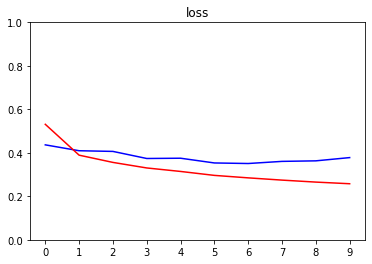

In [15]:
def plot_metrics( train_m , val_m ,title):
  plt.title(title)
  plt.ylim(0,1.0)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_m,color="blue")
  plt.plot(val_m,color="red")

plot_metrics(epoch_train_losses,epoch_val_losses, "loss")

In [17]:
def display_image( image_to_plot, n, y_pred_label, y_real_label):
  plt.figure(figsize=(17,3)) 
  display_strings = [str(i)+"\n\n"+str(j) for i,j in zip(y_pred_label,y_real_label)]
  plt.xticks([28*x+14 for x in range(n)],display_strings )
  image = np.reshape(image_to_plot , [n,28,28])
  image = np.swapaxes( image , 0, 1)
  image = np.reshape( image, [28, 28 * n])
  plt.imshow(image)

10000


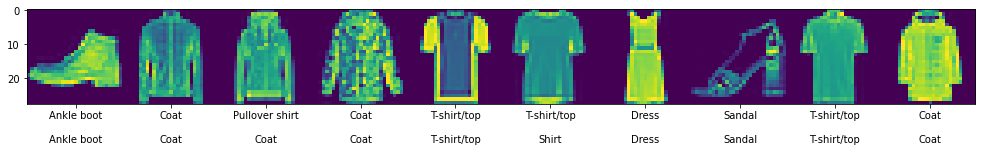

In [18]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_real_batches=[],[],[]

for x,y in test_inputs:
  y_pred = model(x)
  print(len(y_pred))
  y_pred_batches = y_pred.numpy()
  y_real_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)

image_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_real_batches[indexes]


y_pred_label = [ classes_name[np.argmax(j)] for j in y_pred_to_plot]
y_real_label = [ classes_name[i] for i in y_true_to_plot]


display_image( image_to_plot, 10, y_pred_label, y_real_label)